In [26]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
import torch
import pandas as pd
import torch.nn.functional as F

In [28]:
df = pd.read_csv('C:/Users/USER/Documents/semester 2/python/bdc 2024/penyisihan/dataset/dataset_penyisihan_bdc.csv')

In [30]:
import re
import pandas as pd
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import BertTokenizer
from indoNLP.preprocessing import replace_slang, replace_word_elongation

# Definisikan fungsi preprocessing
def preprocess(data, text_column):
    # Mengubah teks menjadi huruf kecil, menghilangkan spasi berlebih, dan menghapus baris baru
    data[text_column] = data[text_column].apply(lambda x: x.lower().strip().replace('\n', ' ').replace('\r', ' '))
    
    # Normalisasi ejaan dan menghapus elongasi
    data[text_column] = data[text_column].apply(replace_slang)
    data[text_column] = data[text_column].apply(replace_word_elongation)
    
    # Menghapus pola tertentu seperti retweet, mentions, URLs, dan hashtags
    data[text_column] = data[text_column].apply(lambda x: re.sub(r're \S+', '', x))
    data[text_column] = data[text_column].apply(lambda x: re.sub(r'@\S+', '', x))
    data[text_column] = data[text_column].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x))
    data[text_column] = data[text_column].apply(lambda x: re.sub(r'#\S+', '', x))
    
    # Menghapus karakter non-alphabet dan menghapus karakter non-ASCII
    data[text_column] = data[text_column].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))
    data[text_column] = data[text_column].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
    
    # Menambahkan stopwords dan kata-kata umum yang tidak diinginkan
    stop = set(stopwords.words('indonesian'))
    kata_umum = {'rt', 'anies', 'baswedan', 'ganjar', 'pranowo', 'prof', 'mahfud', 'md', 
                 'prabowo', 'gibran', 'subianto', 'abah', 'amin', 'yg', 'dkk', 'utk', 
                 'ga', 'nggak', 'gua', 'dgn', 'udah', 'dl', 'dr', 'gw', 'terima kasih',
                 'ya', 'doang', 'nya', 'lu', 'videotron', 'gm', 'sih', 'gak', 'cak imin', 
                 'aja', 'lupa'}
    stop.update(kata_umum)

    # Stemmer untuk bahasa Indonesia
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Fungsi untuk membersihkan dan memproses teks
    def process_text(text):
        # Menghapus stop words
        words = [word for word in text.split() if word not in stop]
        
        # Stemming
        words = [stemmer.stem(word) for word in words]
        
        # Gabungkan kembali kata-kata menjadi string
        return " ".join(words)

    data[text_column] = data[text_column].apply(process_text)

    return data

In [32]:
preprocess(df, 'text').to_csv("C:/Users/USER/Downloads/labeled preprocessed.csv")

In [33]:
df

,text,label
0,kunjung resmi serah proyek bantu air bersih titik,Sumber Daya Alam
1,tepuk tangan riah rektor wajib mata kuliah ant...,Politik
2,dukung goblok dukung ridwan kamil skema balik ...,Demografi
3,sikap kritis kerja anggap sopan anggap hormat ...,Politik
4,harap asn tni polri pegang sumpah milu,Politik
...,...,...
4995,debat kemarin pas kicep kira keluarga laku aks...,Politik
4996,masyarakat milik visi jalan aspirasi rakyat ra...,Politik
4997,imo both a but irrational tbh but nevertheles ...,Ekonomi
4998,look at that kecimpung lgislatif eksekutif bhk...,Pertahanan dan Keamanan


In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [36]:
tokenizer = BertTokenizer.from_pretrained('cahya/bert-base-indonesian-522M')
def tokenize_text(texts, labels):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
    labels = torch.tensor(labels, dtype=torch.long)
    return inputs, labels

In [46]:
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_data, test_data = train_test_split(test, test_size=0.5, random_state=42, stratify=test['label'])

In [47]:
train_inputs, train_labels = tokenize_text(list(train['text']), list(train['label']))
test_inputs, test_labels = tokenize_text(list(test_data['text']), list(test_data['label']))
val_inputs, val_labels = tokenize_text(list(val_data['text']), list(val_data['label']))

In [48]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {'input_ids': self.texts['input_ids'][idx],
                'attention_mask': self.texts['attention_mask'][idx],
                'label': self.labels[idx]}
        return item

In [50]:
model = BertForSequenceClassification.from_pretrained('cahya/bert-base-indonesian-522M', num_labels=len(le.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
train_dataset = TweetDataset(train_inputs, train_labels)
test_dataset = TweetDataset(test_inputs, test_labels)
val_dataset = TweetDataset(val_inputs, val_labels)

In [51]:
training_args = TrainingArguments(
    output_dir='./results_4',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_4',
    logging_steps=10,
)

In [52]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    accuracy = (preds == p.label_ids).astype(float).mean()
    balanced_acc = balanced_accuracy_score(p.label_ids, preds)
    return {
        "accuracy": accuracy,
        "balanced_accuracy": balanced_acc
    }

In [53]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [54]:
trainer.train()

  0%|          | 0/657 [00:00<?, ?it/s]

{'loss': 2.052, 'grad_norm': 10.261983871459961, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.05}
{'loss': 1.9347, 'grad_norm': 11.544153213500977, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.09}
{'loss': 1.7461, 'grad_norm': 5.375725746154785, 'learning_rate': 3e-06, 'epoch': 0.14}
{'loss': 1.4767, 'grad_norm': 4.141409397125244, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.18}
{'loss': 1.3864, 'grad_norm': 6.79132604598999, 'learning_rate': 5e-06, 'epoch': 0.23}
{'loss': 1.397, 'grad_norm': 3.804833173751831, 'learning_rate': 6e-06, 'epoch': 0.27}
{'loss': 1.4592, 'grad_norm': 4.333863258361816, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.32}
{'loss': 1.1507, 'grad_norm': 6.354887008666992, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.37}
{'loss': 1.3755, 'grad_norm': 5.791021347045898, 'learning_rate': 9e-06, 'epoch': 0.41}
{'loss': 1.2518, 'grad_norm': 5.818059921264648, 'learning_rate': 1e-05, 'epoch': 0.46}
{'loss': 1.3897, 'grad_norm': 4.5912718

TrainOutput(global_step=657, training_loss=0.8861043369751905, metrics={'train_runtime': 4324.6649, 'train_samples_per_second': 2.428, 'train_steps_per_second': 0.152, 'total_flos': 690703727616000.0, 'train_loss': 0.8861043369751905, 'epoch': 3.0})

In [55]:
# Simpan model dan tokenizer
model.save_pretrained("./saved_model_4")
tokenizer.save_pretrained("./saved_model_4")

# Atau simpan state dari trainer
trainer.save_state()

In [56]:
model = BertForSequenceClassification.from_pretrained('./saved_model_4')
tokenizer = BertTokenizer.from_pretrained('./saved_model_4')

In [57]:
with torch.no_grad():
    outputs = model(**test_inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

In [58]:
predicted_labels = le.inverse_transform(predictions.numpy())

In [59]:
pred = pd.DataFrame(predicted_labels)[0]

In [61]:
asli = le.inverse_transform(test_labels)

In [62]:
print(f'Balanced Accuracy Score: {balanced_accuracy_score(asli, pred)}')
print(classification_report(asli, pred))

Balanced Accuracy Score: 0.46825251987132077
                         precision    recall  f1-score   support

              Demografi       0.00      0.00      0.00        10
                Ekonomi       0.74      0.71      0.72        55
               Geografi       0.00      0.00      0.00         3
               Ideologi       0.76      0.43      0.55        60
Pertahanan dan Keamanan       0.71      0.73      0.72        60
                Politik       0.78      0.87      0.82       445
          Sosial Budaya       0.60      0.56      0.58        88
       Sumber Daya Alam       0.57      0.45      0.50        29

               accuracy                           0.74       750
              macro avg       0.52      0.47      0.49       750
           weighted avg       0.73      0.74      0.73       750



c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

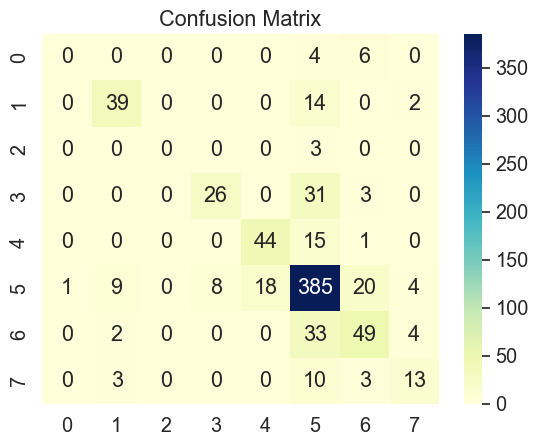

<Figure size 1000x700 with 0 Axes>

In [64]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(asli, pred)
cnf_matrix = pd.DataFrame(cnf_matrix)
sns.set(font_scale=1.3)
axis = plt.axes()
plt.figure(figsize=(10,7))
axis.set_title('Confusion Matrix')
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=axis, cmap='YlGnBu')
plt.show()